## Breakdown into Grid Sections

In [1]:
import pickle
with open('ROMS_26yr_COWed_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

# Remove Outliers
import numpy as np
TD_outlier_threshold = 150000 #m
e150 = {
    eddy: eddies[eddy].index[np.where(eddies[eddy]['Tilt Distance'] > TD_outlier_threshold)[0]].tolist()
    for eddy in eddies.keys()
    if any(eddies[eddy]['Tilt Distance'] > TD_outlier_threshold)
}
for eddy in e150:
    eddies[eddy] = eddies[eddy].drop(e150[eddy])

In [2]:
import netCDF4 as nc
import numpy as np
from datetime import datetime, timedelta

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho']
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho']
lat_rho = np.transpose(lat_rho, axes=(1, 0))
h = dataset.variables['h']
h = np.transpose(h, (1, 0))

def extract_numbers_from_list(strings):
    numbers = [int(''.join(filter(str.isdigit, s))) for s in strings if ''.join(filter(str.isdigit, s))]
    return numbers
def add_days_to_date(days_to_adds):
    new_dates = []
    for day_to_add in days_to_adds:
        day_to_add = day_to_add + 1462
        input_date = '1990-01-01 00:00:00' # Beginning date of file 1462
        if not isinstance(input_date, datetime):
            input_date = datetime.strptime(input_date, '%Y-%m-%d %H:%M:%S')
        if isinstance(day_to_add, np.ndarray):
            day_to_add = day_to_add.item()
        new_date = input_date + timedelta(days=day_to_add)
        new_dates.append(new_date)
    return new_dates
def date_to_season(dates):
    month = dates.month
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'
def month_to_season(month):
    if month in ['Dec', 'Jan', 'Feb']:
        return 'Summer'
    elif month in ['Mar', 'Apr', 'May']:
        return 'Autumn'
    elif month in ['Jun', 'Jul', 'Aug']:
        return 'Winter'
    elif month in ['Sep', 'Oct', 'Nov']:
        return 'Spring'
distinct_colors_for_each_season = {
    'Summer': 'red',
    'Autumn': 'orange',
    'Winter': 'blue',
    'Spring': 'green'
}

ow = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_01461.npy')



In [20]:


tdir, tdis, elon, elat, evort, date, days = [], [], [], [], [], [], []

for eddy in eddies.keys():
    if len(eddies[eddy]) != 0:

        if any(eddies[eddy]['Vort'] < 0):
  
            tdis.extend(eddies[eddy]['Tilt Distance'])
            tdir.extend(eddies[eddy]['Tilt Bearing'])
            elon.extend(eddies[eddy]['Lon'])
            elat.extend(eddies[eddy]['Lat'])
            evort.extend(eddies[eddy]['Vort'])
            days_to_add = extract_numbers_from_list(list(eddies[eddy].index))
            date.extend(add_days_to_date(days_to_add))
            days.extend(days_to_add)

combined = list(zip(tdis, tdir, elon, elat, evort, date, days))
combined_sorted = sorted(combined, key=lambda x: x[0])
tdis_sorted, tdir_sorted, elon_sorted, elat_sorted, evort_sorted, date_sorted, days_sorted = zip(*combined_sorted)

tdis = list(tdis_sorted)
tdir = list(tdir_sorted)
elon = list(elon_sorted)
elat = list(elat_sorted)
evort = list(evort_sorted)
date = list(date_sorted)
days = list(days_sorted)

months = [d.strftime("%b") for d in date]
seasons = [month_to_season(m) for m in months]

In [21]:
import numpy as np
import pandas as pd

def sectioner(i_boundaries,j_boundaries):

    max_i, max_j = lon_rho.shape
    
    # Initialize sections
    num_sections_i = len(i_boundaries) + 1
    num_sections_j = len(j_boundaries) + 1
    sections = {f'sec{i + 1}_{j + 1}': [] for i in range(num_sections_i) for j in range(num_sections_j)}
    
    for lon, lat, tdis0, tdir0, evort0, date0 in zip(elon, elat, tdis, tdir, evort, date):
        R = np.sqrt((lon_rho - lon)**2 + (lat_rho - lat)**2)
        ic, jc = np.where(R == np.min(R))
        ic, jc = (ic[0], jc[0])
        
        # Determine which section the point falls into
        i_section = np.searchsorted(i_boundaries, ic, side='right')
        j_section = np.searchsorted(j_boundaries, jc, side='right')
        
        # Ensure section indices are within bounds
        i_section = min(i_section, num_sections_i - 1)
        j_section = min(j_section, num_sections_j - 1)
        
        section_key = f'sec{i_section + 1}_{j_section + 1}'
        
        if section_key in sections:
            sections[section_key].append((lon, lat, tdis0, tdir0, evort0, date0))

    for section in sections:
        sections[section] = pd.DataFrame(sections[section], columns=['Lon', 'Lat', 'Tilt Distance', 'Tilt Direction', 'Vort', 'Date'])

    
    return sections

In [22]:
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000  # in meters
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS * c

dx = distance(lat_rho[:-1, :], lon_rho[:-1, :], lat_rho[1:, :], lon_rho[1:, :])
dy = distance(lat_rho[:, :-1], lon_rho[:, :-1], lat_rho[:, 1:], lon_rho[:, 1:])


## Section Size

In [23]:
SECTION_SIZE = 150000

checkpoints_x = []
start = 0  # Initialize start at 0

while start < dx.shape[0]:  # Ensure start does not exceed the dimension
    d_checkpoint = start + 2  # Set d_checkpoint to be start + 2
    d = dx[start:d_checkpoint,150]
    
    while d_checkpoint <= dx.shape[0]:
        d = dx[start:d_checkpoint,150]
        d_checkpoint += 1
        if d.sum() > SECTION_SIZE:
            checkpoints_x.append(d_checkpoint)
            break
    start = d_checkpoint  # Move start to the next checkpoint


checkpoints_y = []
start = 0  # Initialize start at 0

while start < dy.shape[1]:  # Ensure start does not exceed the dimension
    d_checkpoint = start + 2  # Set d_checkpoint to be start + 2
    d = dy[150, start:d_checkpoint]
    
    while d_checkpoint <= dy.shape[1]:
        d = dy[150, start:d_checkpoint]
        d_checkpoint += 1
        if d.sum() > SECTION_SIZE:
            checkpoints_y.append(d_checkpoint)
            break
    start = d_checkpoint  # Move start to the next checkpoint



(np.float64(147.07391730247969),
 np.float64(162.25363561382932),
 np.float64(-41.57627817158368),
 np.float64(-25.091913468410354))

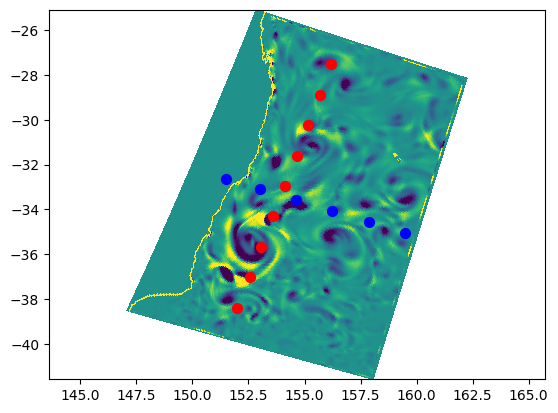

In [24]:
# plt.pcolor(lon_rho[:-1,:],lat_rho[:-1,:],dx)
# plt.pcolor(lon_rho[:,:-1],lat_rho[:,:-1],dy)
import matplotlib.pyplot as plt
plt.pcolor(lon_rho,lat_rho,ow[:,:,0,0],vmin=-1E-9,vmax=1E-9)
for pt in checkpoints_y:
    plt.scatter(lon_rho[150,pt],lat_rho[150,pt],color='r',s=50)
for pt in checkpoints_x:
    plt.scatter(lon_rho[pt, 150],lat_rho[pt, 150],color='b',s=50)
plt.axis('equal')

In [25]:
sections = sectioner(checkpoints_x,checkpoints_y)

(np.float64(147.07391730247969),
 np.float64(162.25363561382932),
 np.float64(-41.57627817158368),
 np.float64(-25.091913468410354))

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


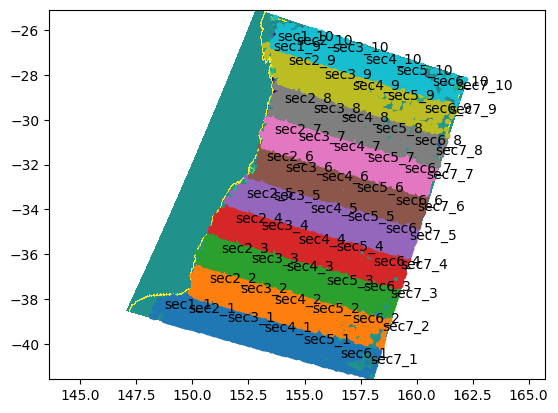

In [26]:
plt.pcolor(lon_rho,lat_rho,ow[:,:,0,0],vmin=-1E-9,vmax=1E-9)

sections = sectioner(checkpoints_x,checkpoints_y)

for section in sections:
    x_coords = sections[section].Lon
    y_coords = sections[section].Lat
    plt.plot(x_coords, y_coords,'.')
    plt.text(np.mean(x_coords), np.mean(y_coords), str(section))
plt.axis('equal')

## Section Breakdown

In [27]:
def max_angle_bin(angles,num_bins):
    angles = list(angles)
    if angles:
        bin_count = [0] * num_bins
        gap = 360/num_bins
        edges = (np.linspace(0,360,16)+gap/2)[:-1]
        for a in angles:
            if 360-gap/2 <= a or a < gap/2:
                bin_count[0] += 1
            else:
                for i in range(0,num_bins-2):
                    if edges[i] <= a < edges[i+1]:
                        bin_count[i+1] += 1
            mean_directions = (np.linspace(0,360,num_bins+1))[:-1]
            max_direction = mean_directions[np.argmax(bin_count)]
    else:       
        max_direction = np.nan
    return max_direction

def calculate_averages(values):
    if len(values) < 2:
        return []
    averages = [(values[i] + values[i+1]) / 2 for i in range(len(values) - 1)]
    return averages

In [28]:
import re
i_indices = []
j_indices = []
for section in sections:
    numbers = re.findall(r'\d+', section)
    numbers = [int(num) for num in numbers]
    i_indices.append(numbers[0])
    j_indices.append(numbers[1])

i_max = int(max(i_indices))
j_max = int(max(j_indices))

TD_averages = np.full((i_max, j_max), np.nan)
centroids_x = np.full((i_max, j_max), np.nan)
centroids_y = np.full((i_max, j_max), np.nan)
num_LTEs = np.full((i_max, j_max), np.nan)
most_common_tilt_direction = np.full((i_max, j_max), np.nan)

num_bins = 16

for section in sections:
    numbers = re.findall(r'\d+', section)
    numbers = [int(num) for num in numbers]
    i = numbers[0]-1
    j = numbers[1]-1
    
    TD_averages[i, j] = np.mean(sections[section]['Tilt Distance'])
    centroids_x[i, j] = np.mean(sections[section].Lon)
    centroids_y[i, j] = np.mean(sections[section].Lat)
    num_LTEs[i, j] = len(sections[section].Lon)

    angles = sections[section]['Tilt Direction']
    most_common_tilt_direction[i,j] = max_angle_bin(angles,num_bins)

width,length = lon_rho.shape
xs = [0]+checkpoints_x+[width]
ys = [0]+checkpoints_y+[length]
x_sec = calculate_averages(xs)
y_sec = calculate_averages(ys)
x_sec = np.tile(x_sec, (j_max, 1)).T.astype(int)
y_sec = np.tile(y_sec, (i_max, 1)).astype(int)
lon_sec = lon_rho[x_sec,y_sec]
lat_sec = lat_rho[x_sec,y_sec]

In [29]:
import random

# Generate 1000 random numbers between 80 and 100
random_numbers_list1 = [random.uniform(300, 360) for _ in range(1000)]
random_numbers_list3 = [random.uniform(0, 60) for _ in range(1000)]
random_numbers_list2 = [random.uniform(0, 360) for _ in range(1000)]
random_numbers_list = random_numbers_list1+random_numbers_list2+random_numbers_list3
max_angle_bin(random_numbers_list,num_bins)

np.float64(22.5)

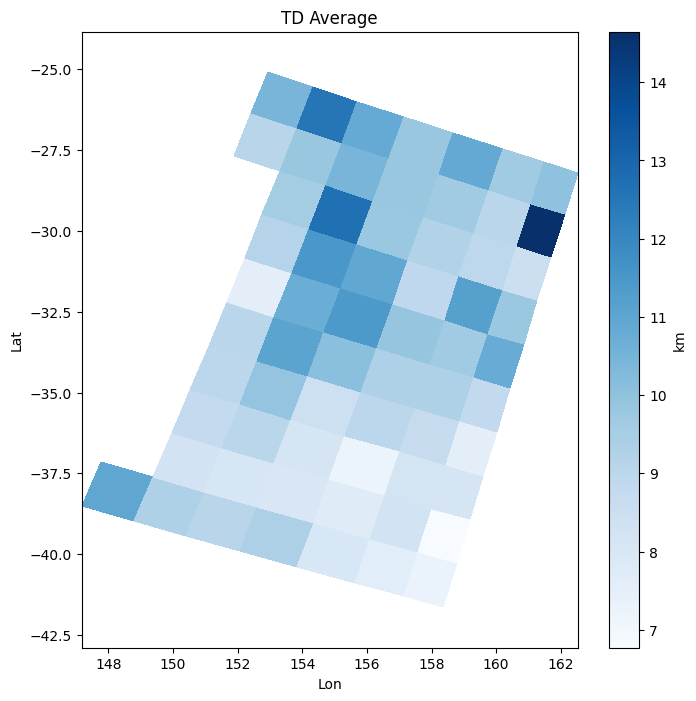

In [34]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(lon_sec,lat_sec,TD_averages/1000, shading='auto', cmap='Blues')
plt.colorbar(label='km')
plt.title('TD Average')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.axis('equal')
plt.show()

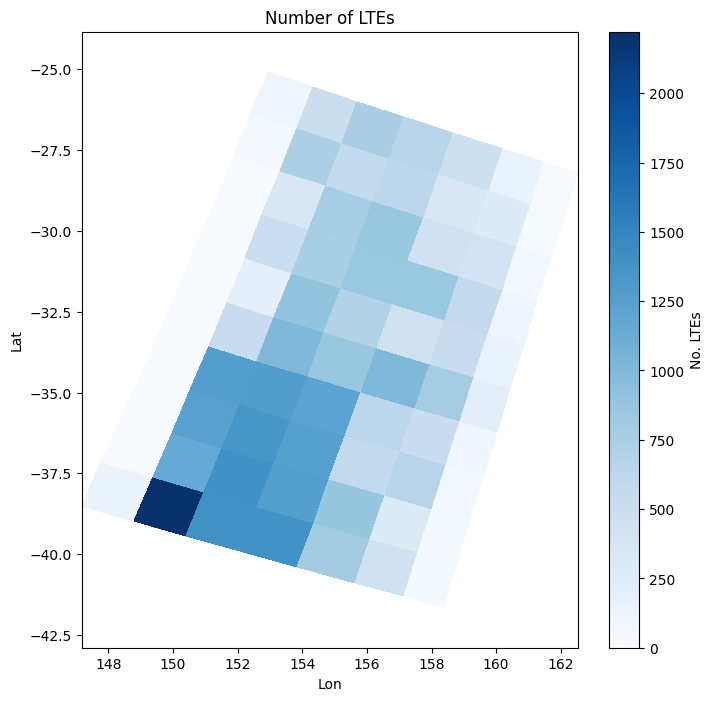

In [35]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(lon_sec,lat_sec,num_LTEs, shading='auto', cmap='Blues')
plt.colorbar(label='No. LTEs')
plt.title('Number of LTEs')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.axis('equal')
plt.show()

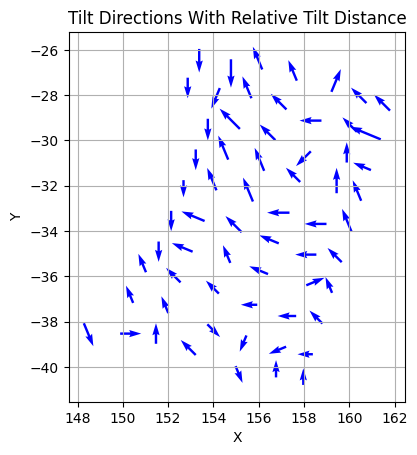

In [36]:
# Convert direction from degrees to radians
directions_rad = np.deg2rad(most_common_tilt_direction.tolist())

# Compute the x and y components of the direction
u = TD_averages.tolist() * np.cos(directions_rad) /10000
v = TD_averages.tolist() * np.sin(directions_rad) /10000

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the quiver
ax.quiver(lon_sec.tolist(), lat_sec.tolist(), u, v, angles='xy', scale_units='xy', scale=1, color='blue')

# Set limits and labels

ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Tilt Directions With Relative Tilt Distance')

plt.grid(True)
plt.show()

/home/z5297792/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


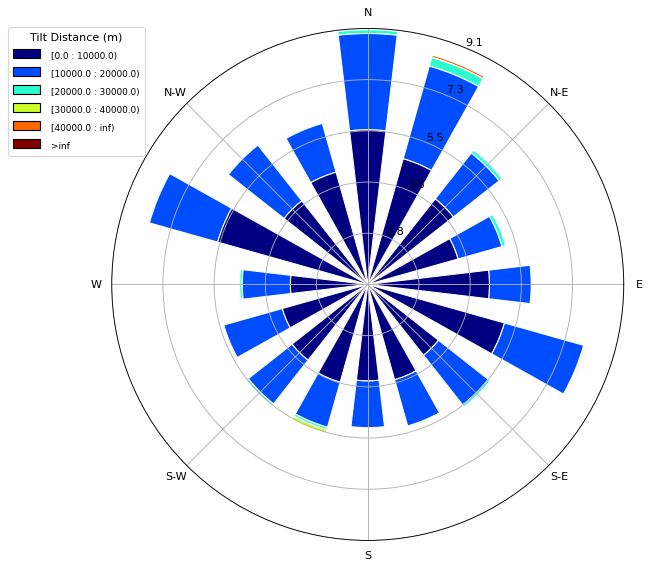

In [37]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm

for section in ['sec2_1']:

    ws = sections[section]['Tilt Distance']
    wd = sections[section]['Tilt Direction']
    
    # Define custom bins
    bins = [0, 10000, 20000, 30000, 40000, np.inf]
    
    
    # Create the Windrose plot
    ax = WindroseAxes.from_ax()
    ax.bar(wd, ws, normed=True, bins=bins, opening=0.6, edgecolor='white', cmap=cm.jet)#_r)
    ax.set_legend(title='Tilt Distance (m)', fontsize='large', loc='upper left', bbox_to_anchor=(-0.2, 1))
    ax.grid(True)
    plt.show()

In [17]:
plt.figure(figsize=(8, 8))
# norm = plt.Normalize(8000, 12000)
sc = plt.scatter(lons, lats, c=np.array(num_LTEs)/np.array(num_eddydays), s =3000)
plt.colorbar(sc, label='Percentage of LTEs (%)')  # Add a colorbar
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Percentage of LTEs (%)')
plt.axis('equal')
plt.show()

NameError: name 'lons' is not defined

<Figure size 800x800 with 0 Axes>

In [ ]:
from scipy.interpolate import griddata

# Define the grid
lon_grid = np.linspace(np.min(elon), np.max(elon), 100)
lat_grid = np.linspace(np.min(elat), np.max(elat), 100)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

# Interpolate onto the grid
units_grid = griddata((elon, elat), tdis, (lon_grid, lat_grid), method='linear')

# Plot the result
plt.figure(figsize=(8, 6))
plt.contourf(lon_grid, lat_grid, units_grid, cmap='viridis')
# plt.scatter(elon, elat, c=tdis, edgecolor='k', marker='o')
plt.colorbar(label='Units')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated Data on Grid')
plt.show()

## All Eddies

In [349]:
import pickle
with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies_all = pickle.load(file)

In [378]:
 elon_all, elat_all, evort_all = [], [], []

for eddy in eddies_all.keys():
    if len(eddies_all[eddy]) != 0:

        # if any(eddies[eddy]['Vort'] < 0):

        elon_all.extend(eddies_all[eddy]['Lon'])
        elat_all.extend(eddies_all[eddy]['Lat'])
        evort_all.extend(eddies_all[eddy]['Vort'])



In [358]:
def sectioner_all(i_boundaries,j_boundaries):

    max_i, max_j = lon_rho.shape
    
    # Initialize sections
    num_sections_i = len(i_boundaries) + 1
    num_sections_j = len(j_boundaries) + 1
    sections = {f'sec{i + 1}_{j + 1}': [] for i in range(num_sections_i) for j in range(num_sections_j)}
    
    for lon, lat, evort0 in zip(elon_all, elat_all, evort_all):
        R = np.sqrt((lon_rho - lon)**2 + (lat_rho - lat)**2)
        ic, jc = np.where(R == np.min(R))
        ic, jc = (ic[0], jc[0])
        
        # Determine which section the point falls into
        i_section = np.searchsorted(i_boundaries, ic, side='right')
        j_section = np.searchsorted(j_boundaries, jc, side='right')
        
        # Ensure section indices are within bounds
        i_section = min(i_section, num_sections_i - 1)
        j_section = min(j_section, num_sections_j - 1)
        
        section_key = f'sec{i_section + 1}_{j_section + 1}'
        
        if section_key in sections:
            sections[section_key].append((lon, lat, evort0))

    for section in sections:
        sections[section] = pd.DataFrame(sections[section], columns=['Lon', 'Lat', 'Vort'])

    
    return sections

In [359]:
sections_all = sectioner_all(checkpoints_x,checkpoints_y)